# <center>Stock Prediction</center>

# Introduction

In this project, we aim to predict stock prices using a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) architecture. LSTMs are particularly suited for time series data like stock prices because they can capture long-term dependencies and patterns in the data.\
We use various techniques to improve the model's accuracy, including data normalization, hyperparameter tuning, and the use of advanced loss functions such as Huber Loss to handle outliers. Throughout the process, the performance of the model will be evaluated using both training and test sets, with special attention paid to preventing overfitting and ensuring generalization.

# Step 1: Loading the data

In this step, the dataset containing stock prices is loaded into the program. The close prices for the stock 'REGN' are extracted for further analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

dataset = pd.read_csv('./all_stocks_5yr.csv')

Using device: mps


In [3]:
dataset_cl = dataset[dataset['Name']=='REGN'].close.values

# Step 2: Cutting our time series into sequences

In this step, we preprocess the data by scaling the stock prices using MinMaxScaler, normalizing them to a range between 0 and 1. We also define a function __processData__ to split the time series into sequences for training. The function takes a look-back window, which here is set to 7 days. This allows the model to learn from the past 7 days of data to predict the next day's stock price.

In [4]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

In [5]:
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)

X, y = processData(dataset_cl, 7)

# Step 3: Split training and testing sets

In this part, the processed sequences are divided into training and testing sets. Typically, 80% of the data is used for training, and the remaining 20% is used for testing. After splitting, the training and testing data are reshaped to fit the LSTM input format, which requires the data to be in a 3D shape: (batch_size, time_steps, features).

In [6]:
X_train, X_test = X[:int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


In [7]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Step 4: Build and run an improved RNN regression model

In this step, we define and build the LSTM model for stock price prediction. The model is a Recurrent Neural Network (RNN) using the LSTM (Long Short-Term Memory) architecture. We use 4 layers of LSTM with 128 hidden units each. Dropout layers are added between the LSTM layers to prevent overfitting, and a fully connected output layer is used to predict the next stock price. The model also supports bidirectional LSTM for improved accuracy.

In [8]:
# class RNN(nn.Module):
#     def __init__(self, i_size, h_size, n_layers, o_size, 
#                  dropout=0.3, bidirectional=True):
#         super(RNN, self).__init__()
#         self.num_directions = 2 if bidirectional else 1
#         self.rnn = nn.LSTM(
#             input_size=i_size,
#             hidden_size=h_size,
#             num_layers=n_layers,
#             dropout=dropout,
#             bidirectional=True
#         )
#         self.out = nn.Linear(h_size * self.num_directions, o_size)

#     def forward(self, x, h_state):
#         r_out, hidden_state = self.rnn(x, h_state)
#         r_out = r_out.view(-1, r_out.size(-1))  # Flatten the LSTM output
#         outs = self.out(r_out)
#         return outs, hidden_state

class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, 
                bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = 2 if bidirectional else 1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            bidirectional=True
        )
        self.out = nn.Linear(h_size * self.num_directions, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        r_out = r_out.view(-1, r_out.size(-1))  # Flatten the LSTM output
        outs = self.out(r_out)
        return outs, hidden_state

In [33]:
# Globals
INPUT_SIZE = 7
HIDDEN_SIZE = 64 
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128

In [34]:
# Hyper parameters
learning_rate = 0.0003
num_epochs = 300

In [35]:
# rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout=0.3)
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
rnn.to(device)

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

hidden_state = None

In [36]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, bidirectional=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [37]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=10)

In [38]:
history = []
X_test_cuda = torch.tensor(X_test).float().to(device)
y_test_cuda = torch.tensor(y_test).float().to(device)

inputs_cuda = torch.tensor(X_train).float().to(device)
labels_cuda = torch.tensor(y_train).float().to(device)

# Step 5: Training the model with updated configuration

In this step, the model is trained using the training data. The Adam optimizer is used to update the model parameters, and the loss is calculated using Huber Loss (SmoothL1Loss), which is more robust to outliers.\
The model is trained over 300 epochs, and every 20 epochs, we check the model's performance on the test set. We also implement early stopping to prevent overfitting if the validation loss does not improve after 10 epochs.

In [ ]:
for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)
    loss = criterion(output[:, 0].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, 
                                                       loss.item(), 
                                                       test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, 
                                         loss.item()))
    history.append(loss.item())

epoch 0, loss 0.10724741965532303, eval loss 0.13265465199947357
epoch 1, loss 0.1000305637717247
epoch 2, loss 0.09307178109884262
epoch 3, loss 0.08635378628969193
epoch 4, loss 0.07985155284404755
epoch 5, loss 0.07354284822940826
epoch 6, loss 0.06740988790988922
epoch 7, loss 0.06143905222415924
epoch 8, loss 0.05562344938516617
epoch 9, loss 0.04996543750166893
epoch 10, loss 0.044478639960289
epoch 11, loss 0.03918985277414322
epoch 12, loss 0.03414164483547211
epoch 13, loss 0.02939571440219879
epoch 14, loss 0.02503669075667858
epoch 15, loss 0.021175812929868698
epoch 16, loss 0.01795267127454281
epoch 17, loss 0.015530785545706749
epoch 18, loss 0.014077693223953247
epoch 19, loss 0.01371303852647543
epoch 20, loss 0.014406577683985233, eval loss 0.0029641559813171625
epoch 21, loss 0.015846792608499527
epoch 22, loss 0.01741836778819561
epoch 23, loss 0.01845088228583336
epoch 24, loss 0.018570508807897568
epoch 25, loss 0.01781015843153
epoch 26, loss 0.016467778012156487


# Step 6: Checking and plotting the training history

After training, we plot the training loss over each epoch to visually check the model's learning process. A steady decrease in loss over time indicates the model is learning effectively. We can also observe if the loss reaches a plateau, which would suggest that further training might not improve the model significantly.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history, 
         label="Training Loss", 
         color='blue', 
         linewidth=2)
plt.title('Training Loss Over Epochs', 
          fontsize=14)
plt.xlabel('Epoch', 
           fontsize=12)
plt.ylabel('Loss', 
           fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

This plot shows the training loss over the course of 300 epochs. We can observe that the training loss decreases significantly in the early epochs and gradually stabilizes after around 50 epochs. This indicates that the model is learning from the data and improving its predictions over time.

# Step 7: Visualizing the results

Finally, we visualize the model's predictions on the test set. The true stock prices are plotted against the predicted stock prices, allowing us to evaluate how well the model generalizes to unseen data. Additionally, we plot the model's fit on both the training and test sets in one graph to compare the performance on each set.

In [29]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
y_test_inv = sc.inverse_transform(y_test.reshape(-1, 1))
test_predict_inv = sc.inverse_transform(test_predict_cpu.reshape(-1, 1))

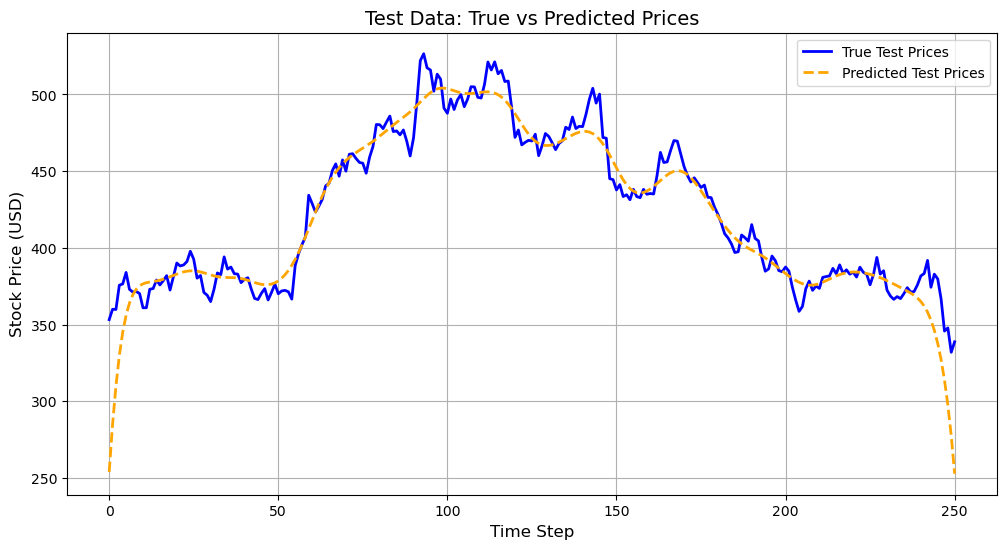

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, 
         label='True Test Prices', 
         color='blue', 
         linewidth=2)
plt.plot(test_predict_inv, 
         label='Predicted Test Prices', 
         color='orange', 
         linestyle='--', 
         linewidth=2)
plt.title('Test Data: True vs Predicted Prices', 
          fontsize=14)
plt.xlabel('Time Step', 
           fontsize=12)
plt.ylabel('Stock Price (USD)', 
           fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

This plot compares the true stock prices (blue line) and the predicted prices (orange dashed line) on the test set. Ideally, the two lines should closely follow each other if the model performs well. In this case, we can see that the predicted prices follow the general trend of the true prices, but there is some deviation in certain areas, indicating room for improvement.

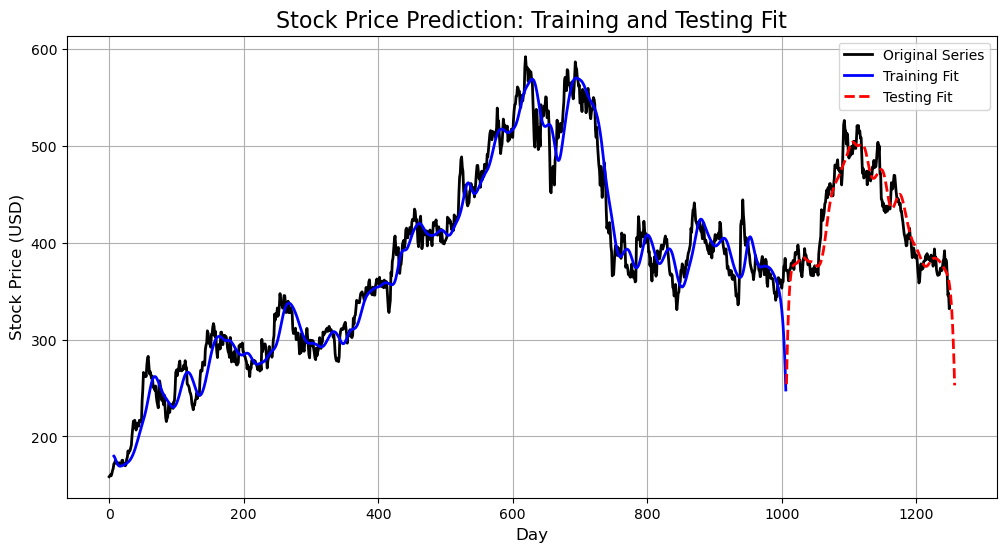

In [31]:
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
train_pred_inv = sc.inverse_transform(train_pred_cpu.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(sc.inverse_transform(y.reshape(-1, 1)), 
         label='Original Series', 
         color='black', 
         linewidth=2)

split_pt = int(X.shape[0] * 0.80) + 7
plt.plot(np.arange(7, split_pt, 1), 
         train_pred_inv, 
         color='blue', 
         label='Training Fit', 
         linewidth=2)

plt.plot(np.arange(split_pt, split_pt + len(test_predict_inv), 1), 
         test_predict_inv, 
         color='red', 
         linestyle='--', 
         label='Testing Fit', 
         linewidth=2)

plt.title('Stock Price Prediction: Training and Testing Fit', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

This plot compares the model's fit on both the training set (blue line) and the test set (red dashed line), against the original stock price series (black line). The blue line closely follows the black line, indicating that the model fits the training data well. However, the red dashed line, which represents the test set, shows some deviation from the black line, suggesting that the model is not generalizing as well to unseen data.

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_test_inv = sc.inverse_transform(y_test.reshape(-1, 1))
test_predict_cpu = test_output.cpu().detach().numpy()
test_predict_inv = sc.inverse_transform(test_predict_cpu.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, test_predict_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, test_predict_inv)
r2 = r2_score(y_test_inv, test_predict_inv)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


Mean Squared Error (MSE): 260.023078404677
Root Mean Squared Error (RMSE): 16.125231111667112
Mean Absolute Error (MAE): 9.840110203716385
R² Score: 0.8945543434084186


# Conclusion

Overall, the model demonstrates a good ability to fit the training data, as evidenced by the steady decline in training loss and close alignment between the training predictions and the actual stock prices. However, the model's performance on the test set is not as strong, indicating potential overfitting.